In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'omission'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
Please

In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data)

All set to analyze


In [3]:
rewarded_df = spike_analysis.wilcox_baseline_v_event_collection('rewarded', 10, 10, plot=False)
both_rewarded_df = spike_analysis.wilcox_baseline_v_event_collection('both_rewarded', 10, 10, plot=False)
tie_df = spike_analysis.wilcox_baseline_v_event_collection('tie', 10, 10, plot=False)
win_df = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10, plot=False)
lose_df = spike_analysis.wilcox_baseline_v_event_collection('lose', 10, 10, plot=False)

C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal ap

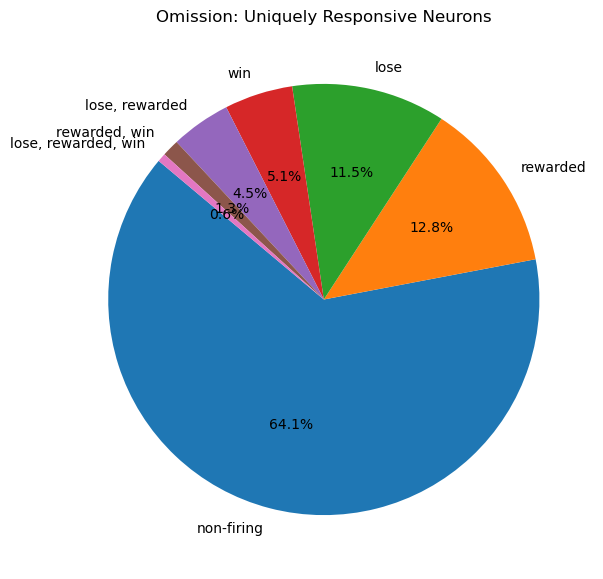

In [4]:
# Step 1: Concatenate the DataFrames
combined_df = pd.concat([rewarded_df, both_rewarded_df, tie_df, win_df, lose_df])

# Function to extract just the event name
def extract_event_name(event):
    # Splits the string and extracts the part before 'vs'
    return event.split(' vs ')[0].replace('10s ', '')

# Initialize an empty dictionary to hold aggregated data
aggregated_data = {}

# Iterate over the rows of the combined DataFrame
for index, row in combined_df.iterrows():
    # Extract event name
    event_name = extract_event_name(row['Event'])
    # Construct a unique key for each combination of recording, subject, and unit id
    key = (row['Recording'], row['Subject'], row['original unit id'])
    
    # Initialize the entry if not exists
    if key not in aggregated_data:
        aggregated_data[key] = {'sig_increase_events': set(), 'sig_decrease_events': set(), 'insig_events': set()}
    
    # Append the event name to the appropriate category based on 'event1 vs event2'
    if row['event1 vs event2'] == 'increases':
        aggregated_data[key]['sig_increase_events'].add(event_name)
    elif row['event1 vs event2'] == 'decreases':
        aggregated_data[key]['sig_decrease_events'].add(event_name)
    else:
        aggregated_data[key]['insig_events'].add(event_name)

# Convert the aggregated data into a DataFrame
rows = []
for (recording, subject, unit_id), categories in aggregated_data.items():
    row = {
        'Recording': recording,
        'Subject': subject,
        'original unit id': unit_id,
        'sig_increase_events': ', '.join(categories['sig_increase_events']),
        'sig_decrease_events': ', '.join(categories['sig_decrease_events']),
        'insig_events': ', '.join(categories['insig_events']),
    }
    rows.append(row)

aggregated_df = pd.DataFrame(rows)

aggregated_df['sig_events'] = aggregated_df.apply(lambda row: ', '.join(filter(None, [row['sig_increase_events'], row['sig_decrease_events']])), axis=1)

# Function to normalize event strings
def normalize_event_string(event_string):
    event_list = event_string.split(', ')
    event_list_sorted = sorted(event_list)  # Sort the list to ensure consistent order
    return ', '.join(event_list_sorted)  # Join the sorted list back into a string

# Apply the normalization function to the 'sig_events' column before counting
aggregated_df['sig_events'] = aggregated_df['sig_events'].apply(normalize_event_string)

# Count the unique combinations of significant events
sig_events_counts = aggregated_df['sig_events'].value_counts()

# Rename the empty strings to 'non-specific'
sig_events_counts = sig_events_counts.rename(index={'': 'non-firing'})

# Group indexes containing ',' into 'multi-event specific'
# sig_events_counts['multi-event'] = sig_events_counts[[',' in index for index in sig_events_counts.index]].sum()
# sig_events_counts = sig_events_counts.drop(sig_events_counts[[',' in index for index in sig_events_counts.index]].index)

# Plot
plt.figure(figsize=(10, 7))
plt.pie(sig_events_counts, labels=sig_events_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Omission: Uniquely Responsive Neurons')
plt.show()
# plt.savefig('Omission_Wilcoxon_Pie_Plot.png', bbox_inches='tight')

In [5]:
aggregated_df.to_csv('Omission_Wilcoxon_events.csv', index=False)

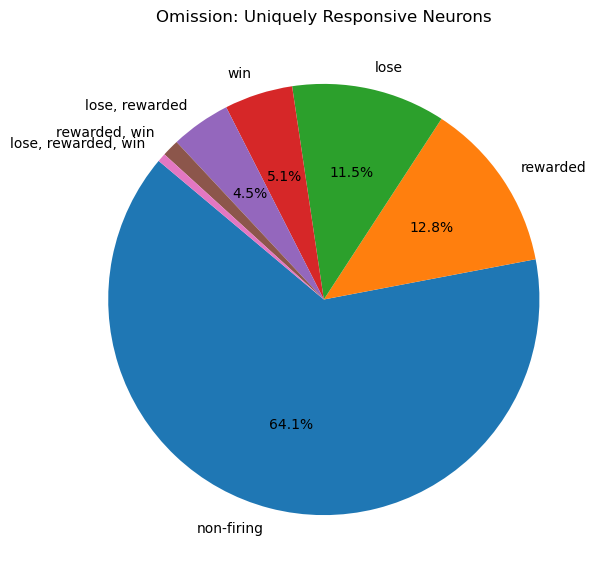

In [6]:
import matplotlib.pyplot as plt

# Custom function to display percentages
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct >= 4 else ''

# Pie chart creation
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(sig_events_counts, labels=sig_events_counts.index, autopct=custom_autopct, startangle=140)

plt.title('Omission: Uniquely Responsive Neurons')

# Customize the placement of labels for small slices
for i, pct in enumerate(sig_events_counts * 100 / sig_events_counts.sum()):
    if pct < 4:
        x, y = wedges[i].theta1, wedges[i].r
        label = f"{sig_events_counts.index[i]}: {pct:1.1f}%"
        plt.annotate(label, xy=(x, y), xytext=(1.35 * np.cos(np.deg2rad(x)), 1.35 * np.sin(np.deg2rad(x))),
                     textcoords='data', ha='center', va='center')

plt.show()


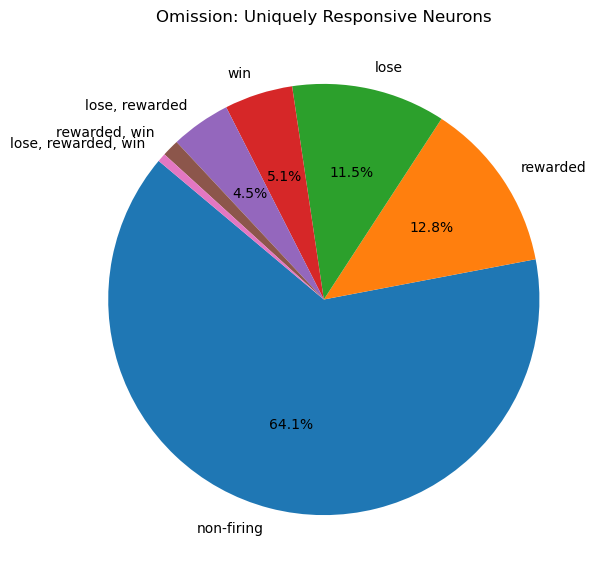

In [7]:
import matplotlib.pyplot as plt

# Custom function to display percentages
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct >= 4 else ''

# Pie chart creation
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(sig_events_counts, labels=sig_events_counts.index, autopct=custom_autopct, startangle=140)

plt.title('Omission: Uniquely Responsive Neurons')

plt.show()

In [8]:
plt.savefig('Omission_Wilcoxon_Pie_Plot_all_multi.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

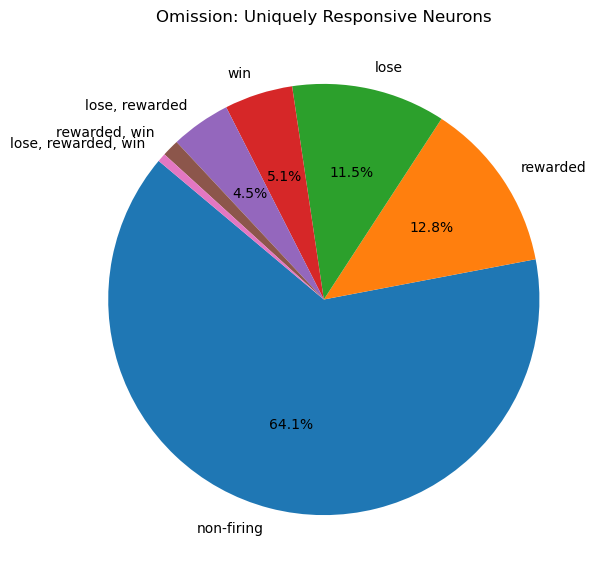

In [9]:
import matplotlib.pyplot as plt

# Custom function to display percentages
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct >= 4 else ''

# Pie chart creation
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(sig_events_counts, labels=sig_events_counts.index, autopct=custom_autopct, startangle=140)

plt.title('Omission: Uniquely Responsive Neurons')

plt.savefig('Omission_Wilcoxon_Pie_Plot_all_multi.png', bbox_inches='tight')